In [1]:
# changing cwd
%cd ..

c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp


## Load packages

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np

from src.inductive_bias import IB
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle

cmap = 'PRGn'

In [3]:
from src.inductive_bias import IB
ib = IB() #instantiate inductive bias package

[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\SimulationData.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\PosteriorData.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\TrainedCLF.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\EstimatedData.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\HellingerData.pickle ] loaded
Size of the S-XOR: (6322,)                    
Size of the Spiral: (6276,)                    
Size of the whole dataset: (12598, 7)
(6322, 7) [0.51478151 0.35290859 0.49991263 ... 0.17697081 0.01428646 0.02154132]

Size of the S-XOR after adding hellinger: (6322, 8)            
Size of the Spiral after adding hellinger: (6276, 8)


## Time and Date of the experiment

In [4]:
print(ib.date)

2021-04-06 00:08:35.370467


In [5]:
uX = ib.mask
uX0, uX1 = uX[:,0], uX[:,1]
label = ib.mtype[:3] + ['Human'] #excluding QDA
fsize= 18

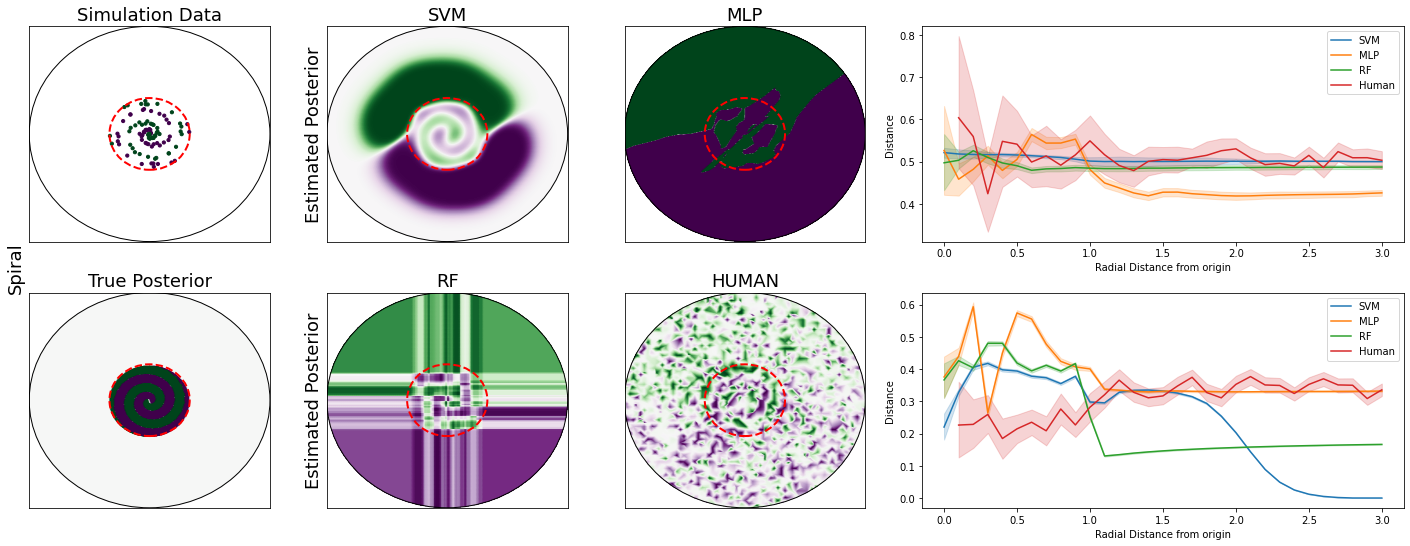

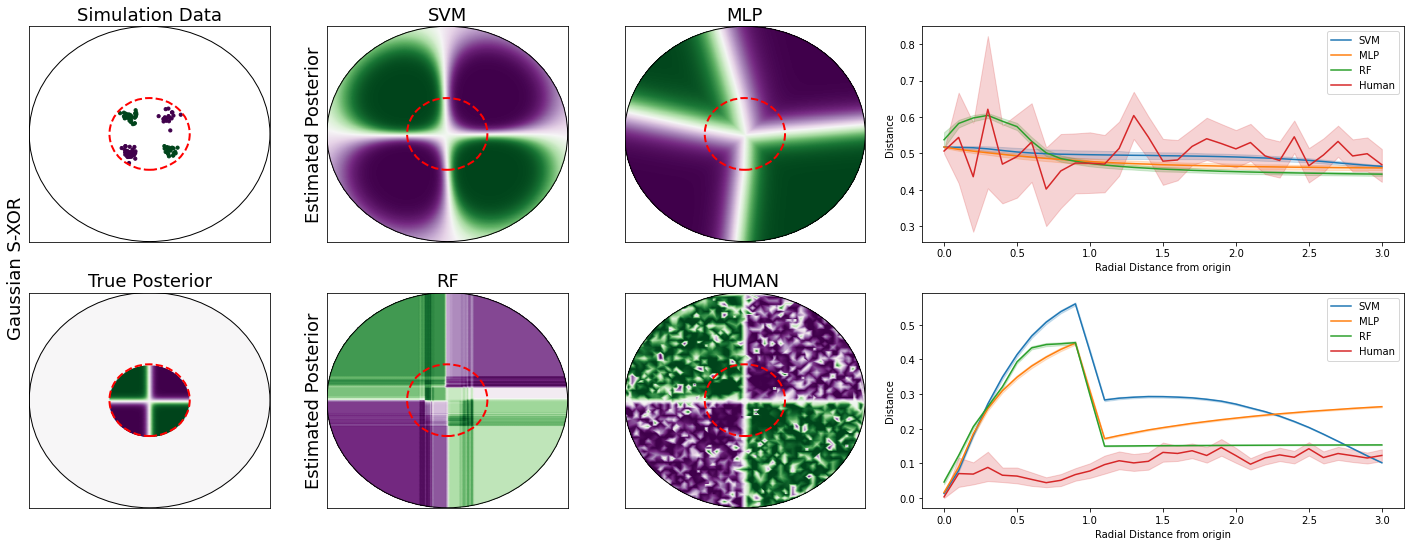

In [8]:
'''
This figure contains simulation data at idx[0,0], true posterior at idx[1,0], 
estimated posterior at idx[i=1,2|j=1,2], class 1 posterior at idx[0,3], and hellinger distance at idx[1,3]
'''

row = 2
col = 4
interp_method = 'linear'  # interpolation methods
fname = ['spiral', 'sxor']

for ii, j in enumerate([2, 4]):#enumerate(range(2)):

    cnt = 0

    widths = [4, 4, 4, 8]
    fig = plt.figure(figsize=(4*(col+1), 4*row))
    spec = fig.add_gridspec(ncols=col, nrows=row, width_ratios=widths)

    ax = fig.add_subplot(111)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')

    ax.set_ylabel(ib.dtype[j], fontsize=18)

    for k in range(row):
        for i in range(col):
            cnt += 1

            axs = fig.add_subplot(spec[k, i])

            # simulation dataset
            if cnt == 1:
                pcm = axs.scatter(ib.train_X[j][:,0], ib.train_X[j][:,1], c=ib.train_y[j], cmap=cmap, s=10)

            # true posterior
            elif cnt == 5:
                xx = ib.truepst[1][j][0]
                yy = ib.truepst[1][j][1]
                cc = ib.truepst[1][j][2]
                pcm = axs.scatter(xx, yy, c=cc, cmap=cmap, s=1)

            # estimated posterior (SVM)
            elif cnt == 2:
                pcm = axs.scatter(uX0, uX1, c=ib.estpst[1][j][0], cmap=cmap, s=1)
                axs.set_title(ib.mtype[0], fontsize=fsize)

            # estimated posterior (MLP)
            elif cnt == 3:
                pcm = axs.scatter(uX0, uX1, c=ib.estpst[1][j][1], cmap=cmap, s=1)
                axs.set_title(ib.mtype[1], fontsize=fsize)

            # estimated posterior (RF)
            elif cnt == 6:
                pcm = axs.scatter(uX0, uX1, c=ib.estpst[1][j][2], cmap=cmap, s=1)
                axs.set_title(ib.mtype[2], fontsize=fsize)

            # human estimates
            elif cnt == 7:
                grid_near = griddata((ib.human[ii][:, 3], ib.human[ii][:, 5]), ib.human[ii][:, 0], (uX0, uX1), method=interp_method, rescale=False)  # , fill_value=0.5
                pcm = axs.scatter(uX0, uX1, c=grid_near, cmap=cmap, s=1)
                axs.set_title('HUMAN', fontsize=fsize)

            # radial plot
            elif cnt == 4 or cnt == 8:
                for i in range(4):
                    
                    if i == 3:        
                        hmask = np.column_stack([ib.human[ii][:,3], ib.human[ii][:,5]])
                        if cnt == 4:
                            temp = ib.get_radialDist(np.column_stack([hmask, ib.human[ii][:,0]]).astype(float))
                        elif cnt == 8:
                            temp = ib.get_radialDist(np.column_stack([hmask, ib.human[ii][:,6]]).astype(float))
                    else:
                        if cnt == 4:
                            temp = ib.get_radialDist(np.column_stack([ib.mask, ib.estpst[1][j][i]]))
                        elif cnt == 8:
                            temp = ib.get_radialDist(np.column_stack([ib.mask, ib.hdist[1][j][i]]))

                    temp2 = pd.DataFrame(temp[1]).T
                    temp2.columns = temp[0]
                    temp2 = temp2.melt().dropna()
                    temp2.columns=['Radial Distance from origin', 'Distance']
                    sns.lineplot(data=temp2, x=temp2.columns[0], y=temp2.columns[1], ci=95, label=label[i], ax=axs)
            
            ## figure styling ##
            if cnt != 4 and cnt != 8:
                # outer bounding circle
                circle = Circle((0, 0), 3, linewidth=1, edgecolor='k', facecolor='none')
                # inner unit circle
                axs.add_patch(Circle((0, 0), radius=1, linewidth=2, ls='--', edgecolor='r', fill=False))
                axs.add_patch(circle)
                pcm.set_clip_path(circle)

                axs.set_xlim([-3, 3])
                axs.set_ylim([-3, 3])

            if k == 0 and i == 0:
                axs.set_title('Simulation Data', fontsize=fsize)

            if k == 1 and i == 0:
                axs.set_title('True Posterior', fontsize=fsize)

            if i == 1 and (k == 0 or k == 1):
                axs.set_ylabel('Estimated Posterior', fontsize=fsize)

            if i < 3:
                axs.set_xticks([])
                axs.set_yticks([])

    plt.tight_layout(pad=2)
    plt.savefig(f'figs/[20210330_model_human_plot]_model_human_figure_{fname[ii]}_{str(ib.date.date())}.png', bbox_inches='tight')


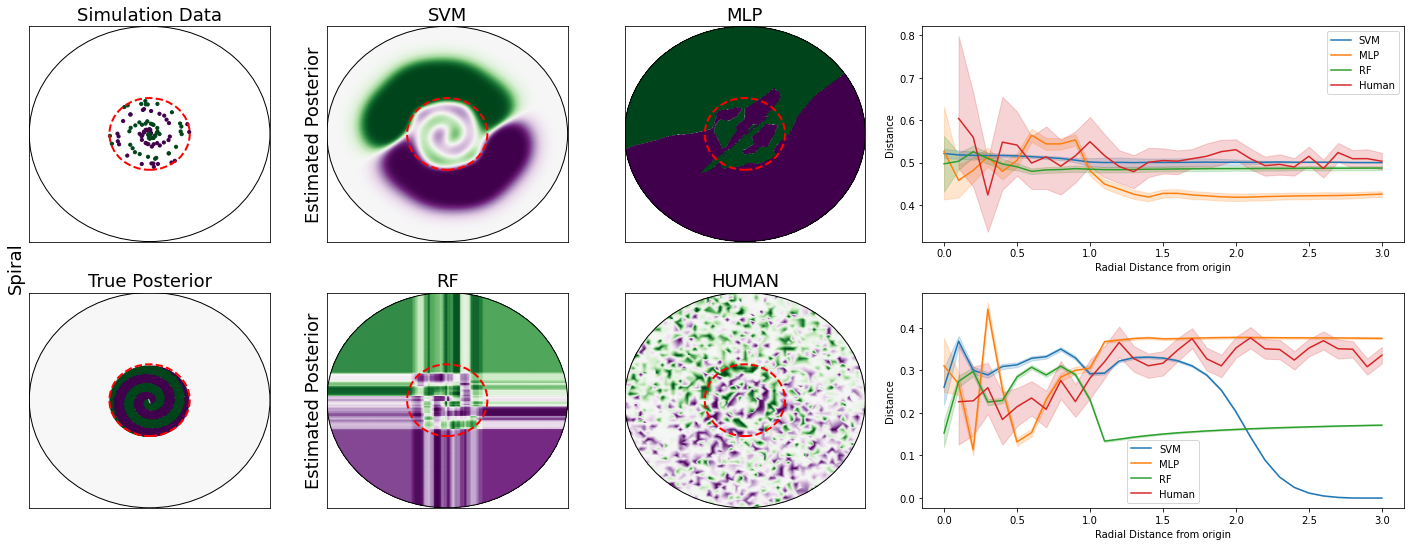

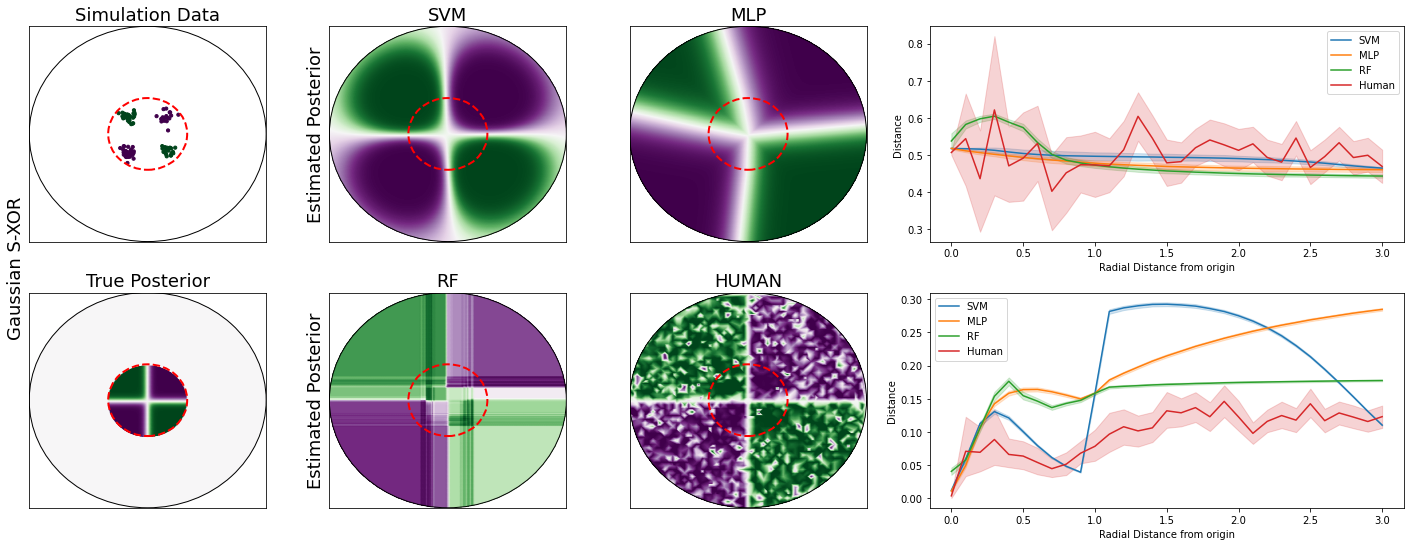

In [20]:
'''
This figure contains simulation data at idx[0,0], true posterior at idx[1,0], 
estimated posterior at idx[i=1,2|j=1,2], class 1 posterior at idx[0,3], and hellinger distance at idx[1,3]
'''

row = 2
col = 4
interp_method = 'linear'  # interpolation methods
fname = ['spiral', 'sxor']

for ii, j in enumerate([2, 4]):#enumerate(range(2)):

    cnt = 0

    widths = [4, 4, 4, 8]
    fig = plt.figure(figsize=(4*(col+1), 4*row))
    spec = fig.add_gridspec(ncols=col, nrows=row, width_ratios=widths)

    ax = fig.add_subplot(111)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')

    ax.set_ylabel(ib.dtype[j], fontsize=18)

    for k in range(row):
        for i in range(col):
            cnt += 1

            axs = fig.add_subplot(spec[k, i])

            # simulation dataset
            if cnt == 1:
                pcm = axs.scatter(ib.train_X[j][:,0], ib.train_X[j][:,1], c=ib.train_y[j], cmap=cmap, s=10)

            # true posterior
            elif cnt == 5:
                xx = ib.truepst[1][j][0]
                yy = ib.truepst[1][j][1]
                cc = ib.truepst[1][j][2]
                pcm = axs.scatter(xx, yy, c=cc, cmap=cmap, s=1)

            # estimated posterior (SVM)
            elif cnt == 2:
                pcm = axs.scatter(uX0, uX1, c=ib.estpst[1][j][0], cmap=cmap, s=1)
                axs.set_title(ib.mtype[0], fontsize=fsize)

            # estimated posterior (MLP)
            elif cnt == 3:
                pcm = axs.scatter(uX0, uX1, c=ib.estpst[1][j][1], cmap=cmap, s=1)
                axs.set_title(ib.mtype[1], fontsize=fsize)

            # estimated posterior (RF)
            elif cnt == 6:
                pcm = axs.scatter(uX0, uX1, c=ib.estpst[1][j][2], cmap=cmap, s=1)
                axs.set_title(ib.mtype[2], fontsize=fsize)

            # human estimates
            elif cnt == 7:
                grid_near = griddata((ib.human[ii][:, 3], ib.human[ii][:, 5]), ib.human[ii][:, 0], (uX0, uX1), method=interp_method, rescale=False)  # , fill_value=0.5
                pcm = axs.scatter(uX0, uX1, c=grid_near, cmap=cmap, s=1)
                axs.set_title('HUMAN', fontsize=fsize)

            # radial plot
            elif cnt == 4 or cnt == 8:
                for i in range(4):
                    
                    if i == 3:        
                        hmask = np.column_stack([ib.human[ii][:,3], ib.human[ii][:,5]])
                        if cnt == 4:
                            temp = ib.get_radialDist(np.column_stack([hmask, ib.human[ii][:,0]]).astype(float))
                        elif cnt == 8:
                            temp = ib.get_radialDist(np.column_stack([hmask, ib.human[ii][:,6]]).astype(float))
                    else:
                        if cnt == 4:
                            temp = ib.get_radialDist(np.column_stack([ib.mask, ib.estpst[1][j][i]]))
                        elif cnt == 8:
                            temp = ib.get_radialDist(np.column_stack([ib.mask, ib.hdist[1][j][i]]))

                    temp2 = pd.DataFrame(temp[1]).T
                    temp2.columns = temp[0]
                    temp2 = temp2.melt().dropna()
                    temp2.columns=['Radial Distance from origin', 'Distance']
                    sns.lineplot(data=temp2, x=temp2.columns[0], y=temp2.columns[1], ci=95, label=label[i], ax=axs)
            
            ## figure styling ##
            if cnt != 4 and cnt != 8:
                # outer bounding circle
                circle = Circle((0, 0), 3, linewidth=1, edgecolor='k', facecolor='none')
                # inner unit circle
                axs.add_patch(Circle((0, 0), radius=1, linewidth=2, ls='--', edgecolor='r', fill=False))
                axs.add_patch(circle)
                pcm.set_clip_path(circle)

                axs.set_xlim([-3, 3])
                axs.set_ylim([-3, 3])

            if k == 0 and i == 0:
                axs.set_title('Simulation Data', fontsize=fsize)

            if k == 1 and i == 0:
                axs.set_title('True Posterior', fontsize=fsize)

            if i == 1 and (k == 0 or k == 1):
                axs.set_ylabel('Estimated Posterior', fontsize=fsize)

            if i < 3:
                axs.set_xticks([])
                axs.set_yticks([])

    plt.tight_layout(pad=2)
    plt.savefig(f'figs/[20210330_model_human_plot]_model_human_figure_{fname[ii]}_{str(ib.date.date())}.png', bbox_inches='tight')
